In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import keras_tuner as kt

In [4]:
data = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha')
data = data.asfreq('D')

In [5]:
end_train = '2021-12-31'
end_validation = '2023-08-13'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2019-01-01 00:00:00 --- 2021-12-31 00:00:00  (n=1096)
Dates validacion : 2021-12-31 00:00:00 --- 2023-08-13 00:00:00  (n=591)
Dates test       : 2023-08-13 00:00:00 --- 2024-09-26 00:00:00  (n=411)


In [6]:
# Separar la variable objetivo y las variables exógenas
target_column = 'demanda'
#exogenous_columns = data.columns.difference([target_column]).tolist()
exogenous_columns = ['diasem', 'trim', 'festivo', 'tmed']

# Escalar solo la columna objetivo
scaler_target = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler_target.fit_transform(data[[target_column]])

# Escalar las variables exógenas
scaler_exogenous = MinMaxScaler(feature_range=(0, 1))
data[exogenous_columns] = scaler_exogenous.fit_transform(data[exogenous_columns])


In [7]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Incluye todas las columnas
        y.append(data[i + time_step, 0])  # Solo la columna de demanda
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana (número de pasos de tiempo)
time_step = 7

# Crear secuencias para cada conjunto de datos
scaled_data = data.values  # Convierte a un array Numpy
X_train, y_train = create_dataset(scaled_data[:len(data_train)], time_step)
X_val, y_val = create_dataset(scaled_data[len(data_train):len(data_train) + len(data_val)], time_step)
X_test, y_test = create_dataset(scaled_data[len(data_train) + len(data_val):], time_step)

# Reshape de X para ser [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


In [21]:
# Crear el modelo RNN con LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # Varias columnas
model.add(Dropout(0.05))
model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.05))
model.add(Dense(35))
model.add(Dense(1))  # Salida para la demanda

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()


c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 7, 100)         │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10)             │         4,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 35)             │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,661 (186.18 KB)

 Trainable params: 47,661 (186.18 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Entrenar el modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.1102 - val_loss: 0.0538
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0377 - val_loss: 0.0391
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0350 - val_loss: 0.0411
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0337 - val_loss: 0.0418
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0364 - val_loss: 0.0457
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0346 - val_loss: 0.0406
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0362 - val_loss: 0.0382
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0325 - val_loss: 0.0364
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0324 - val_loss: 0.0418
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0329 - val_loss: 0.0360
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0307 - val_loss: 0.0383
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

In [23]:
# Hacer predicciones
predictions = model.predict(X_test)

# Invertir la escala de las predicciones
predictions = predictions.reshape(-1, 1)  # Cambiar a forma (n_samples, 1)
predictions = scaler_target.inverse_transform(predictions)  # Invertir solo la columna de demanda

# Invertir la escala de los valores reales
y_test_scaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


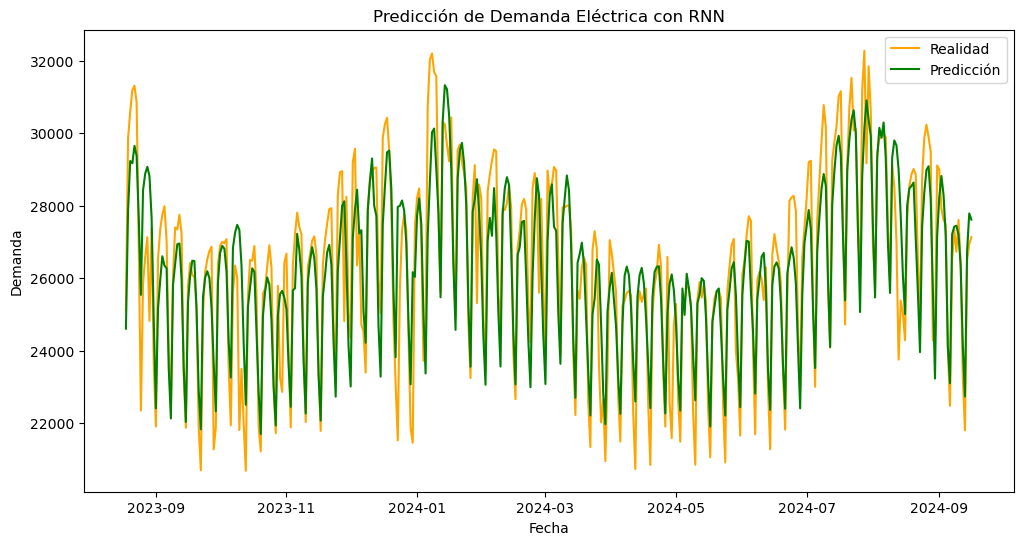

MAE: 974.91


In [24]:
# Visualizar las predicciones
plt.figure(figsize=(12, 6))

# Crear un rango de fechas que coincide con las predicciones
date_range = data_test.index[time_step: len(predictions) + time_step]

plt.plot(date_range, y_test_scaled, label='Realidad', color='orange')
plt.plot(date_range, predictions, label='Predicción', color='green')

plt.title('Predicción de Demanda Eléctrica con RNN')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

# Calcular MAE
mae = mean_absolute_error(y_test_scaled, predictions)
print(f'MAE: {mae:.2f}')


In [32]:
# Función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros
    n_units = trial.suggest_int('n_units', 10, 100)  # Número de unidades LSTM
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
    batch_size = trial.suggest_int('batch_size', 16, 64)  # Tamaño del batch
    n_epochs = trial.suggest_int('n_epochs', 10, 100)  # Número de épocas

    # Crear el modelo LSTM
    model = Sequential()
    model.add(LSTM(n_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, 
              validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Predecir y calcular MAE
    predictions = model.predict(X_test)
    predictions = predictions.reshape(-1, 1)  # Cambiar a forma (n_samples, 1)
    predictions = scaler_target.inverse_transform(predictions)  # Invertir escala
    y_test_scaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))  # Invertir escala

    # Calcular y devolver el MAE
    mae = mean_absolute_error(y_test_scaled, predictions)
    return mae

# Configurar y ejecutar el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(study.best_params)
print("Mejor MAE:", study.best_value)

[I 2024-10-20 14:31:59,549] A new study created in memory with name: no-name-3016fc72-a687-4bcb-8922-0cf75855b286
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-10-20 14:32:11,260] Trial 0 finished with value: 1670.1632447522095 and parameters: {'n_units': 87, 'learning_rate': 0.0002834671113405647, 'batch_size': 43, 'n_epochs': 42}. Best is trial 0 with value: 1670.1632447522095.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[I 2024-10-20 14:32:27,514] Trial 1 finished with value: 912.2147403724747 and parameters: {'n_units': 58, 'learning_rate': 3.601501538432377e-05, 'batch_size': 47, 'n_epochs': 69}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-10-20 14:32:39,859] Trial 2 finished with value: 1822.3300175583963 and parameters: {'n_units': 43, 'learning_rate': 0.002228995182799299, 'batch_size': 33, 'n_epochs': 47}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


[I 2024-10-20 14:32:47,708] Trial 3 finished with value: 2039.23818911774 and parameters: {'n_units': 67, 'learning_rate': 1.1774359868783962e-05, 'batch_size': 39, 'n_epochs': 15}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-10-20 14:33:03,760] Trial 4 finished with value: 1524.6239579387625 and parameters: {'n_units': 59, 'learning_rate': 0.00011726653163911625, 'batch_size': 53, 'n_epochs': 65}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


[I 2024-10-20 14:33:22,131] Trial 5 finished with value: 1047.5205295138887 and parameters: {'n_units': 74, 'learning_rate': 0.08873189214192617, 'batch_size': 48, 'n_epochs': 74}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-10-20 14:33:30,327] Trial 6 finished with value: 1892.7315524384471 and parameters: {'n_units': 89, 'learning_rate': 1.928148945980788e-05, 'batch_size': 37, 'n_epochs': 15}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[I 2024-10-20 14:33:40,118] Trial 7 finished with value: 1693.7237612452652 and parameters: {'n_units': 25, 'learning_rate': 7.412730086894875e-05, 'batch_size': 38, 'n_epochs': 26}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-10-20 14:33:57,897] Trial 8 finished with value: 1094.1620503866793 and parameters: {'n_units': 99, 'learning_rate': 0.019661199280203902, 'batch_size': 35, 'n_epochs': 46}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-10-20 14:34:09,432] Trial 9 finished with value: 1972.536390664457 and parameters: {'n_units': 55, 'learning_rate': 0.0018168175179983236, 'batch_size': 39, 'n_epochs': 43}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-10-20 14:34:16,643] Trial 10 finished with value: 2319.418085740215 and parameters: {'n_units': 17, 'learning_rate': 0.00039530378137152456, 'batch_size': 64, 'n_epochs': 98}. Best is trial 1 with value: 912.2147403724747.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-10-20 14:34:40,142] Trial 11 finished with value: 833.0131269728535 and parameters: {'n_units': 75, 'learning_rate': 0.04540196001996924, 'batch_size': 20, 'n_epochs': 78}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-10-20 14:35:02,824] Trial 12 finished with value: 963.0474976325758 and parameters: {'n_units': 40, 'learning_rate': 0.00688412185188755, 'batch_size': 18, 'n_epochs': 82}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2024-10-20 14:35:18,010] Trial 13 finished with value: 986.9647279434973 and parameters: {'n_units': 75, 'learning_rate': 0.09882706781498647, 'batch_size': 19, 'n_epochs': 92}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[I 2024-10-20 14:35:29,880] Trial 14 finished with value: 1583.3849275962755 and parameters: {'n_units': 48, 'learning_rate': 0.01525063815634356, 'batch_size': 26, 'n_epochs': 66}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-10-20 14:35:46,992] Trial 15 finished with value: 1096.557203677399 and parameters: {'n_units': 65, 'learning_rate': 4.15882926645613e-05, 'batch_size': 56, 'n_epochs': 83}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2024-10-20 14:35:53,115] Trial 16 finished with value: 2263.121269728535 and parameters: {'n_units': 34, 'learning_rate': 0.000551678563120399, 'batch_size': 30, 'n_epochs': 62}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


[I 2024-10-20 14:36:04,225] Trial 17 finished with value: 1421.9228847064396 and parameters: {'n_units': 81, 'learning_rate': 0.004110040929258174, 'batch_size': 45, 'n_epochs': 79}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-10-20 14:36:28,475] Trial 18 finished with value: 917.4060345643938 and parameters: {'n_units': 100, 'learning_rate': 0.01966345481044806, 'batch_size': 24, 'n_epochs': 91}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


[I 2024-10-20 14:36:44,144] Trial 19 finished with value: 1142.106098879419 and parameters: {'n_units': 52, 'learning_rate': 0.00011911633556229073, 'batch_size': 51, 'n_epochs': 56}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


[I 2024-10-20 14:37:00,942] Trial 20 finished with value: 975.9368248895203 and parameters: {'n_units': 67, 'learning_rate': 0.000919224549622937, 'batch_size': 60, 'n_epochs': 72}. Best is trial 11 with value: 833.0131269728535.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-10-20 14:37:19,123] Trial 21 finished with value: 807.7676296164773 and parameters: {'n_units': 99, 'learning_rate': 0.028250371953225325, 'batch_size': 25, 'n_epochs': 91}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2024-10-20 14:37:44,398] Trial 22 finished with value: 854.2856816208964 and parameters: {'n_units': 90, 'learning_rate': 0.04068949097434908, 'batch_size': 22, 'n_epochs': 89}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[I 2024-10-20 14:38:11,497] Trial 23 finished with value: 820.089366122159 and parameters: {'n_units': 92, 'learning_rate': 0.04165758791627882, 'batch_size': 16, 'n_epochs': 90}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


[I 2024-10-20 14:38:43,342] Trial 24 finished with value: 869.9527300347222 and parameters: {'n_units': 94, 'learning_rate': 0.04152416917466245, 'batch_size': 16, 'n_epochs': 98}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2024-10-20 14:39:02,771] Trial 25 finished with value: 1331.9596959832704 and parameters: {'n_units': 81, 'learning_rate': 0.006452061134971611, 'batch_size': 28, 'n_epochs': 86}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


[I 2024-10-20 14:39:35,824] Trial 26 finished with value: 815.0249360795453 and parameters: {'n_units': 82, 'learning_rate': 0.041636301114544395, 'batch_size': 21, 'n_epochs': 100}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2024-10-20 14:40:01,850] Trial 27 finished with value: 850.910520636048 and parameters: {'n_units': 84, 'learning_rate': 0.011093095333538461, 'batch_size': 23, 'n_epochs': 93}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2024-10-20 14:40:17,091] Trial 28 finished with value: 1892.0368718434345 and parameters: {'n_units': 97, 'learning_rate': 0.03134329186784287, 'batch_size': 31, 'n_epochs': 96}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2024-10-20 14:40:48,309] Trial 29 finished with value: 1604.3331794507574 and parameters: {'n_units': 90, 'learning_rate': 0.06994078758634903, 'batch_size': 16, 'n_epochs': 85}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2024-10-20 14:41:08,162] Trial 30 finished with value: 904.705734887942 and parameters: {'n_units': 94, 'learning_rate': 0.0031169179294836835, 'batch_size': 27, 'n_epochs': 34}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[I 2024-10-20 14:41:26,709] Trial 31 finished with value: 1876.6319517440027 and parameters: {'n_units': 75, 'learning_rate': 0.04278320525953266, 'batch_size': 21, 'n_epochs': 100}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2024-10-20 14:42:00,324] Trial 32 finished with value: 889.3097741082702 and parameters: {'n_units': 81, 'learning_rate': 0.009330608533491798, 'batch_size': 20, 'n_epochs': 76}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2024-10-20 14:42:39,630] Trial 33 finished with value: 859.881430318813 and parameters: {'n_units': 88, 'learning_rate': 0.028750913264699033, 'batch_size': 25, 'n_epochs': 88}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2024-10-20 14:42:55,429] Trial 34 finished with value: 1180.1635347616793 and parameters: {'n_units': 73, 'learning_rate': 0.058616848822588274, 'batch_size': 18, 'n_epochs': 81}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2024-10-20 14:43:16,463] Trial 35 finished with value: 902.3691619318181 and parameters: {'n_units': 93, 'learning_rate': 0.017752592576481943, 'batch_size': 22, 'n_epochs': 78}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2024-10-20 14:43:31,333] Trial 36 finished with value: 1945.2475749684343 and parameters: {'n_units': 85, 'learning_rate': 0.025845316693269164, 'batch_size': 29, 'n_epochs': 56}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


[I 2024-10-20 14:43:49,965] Trial 37 finished with value: 1769.8871916429923 and parameters: {'n_units': 61, 'learning_rate': 0.0528669564701535, 'batch_size': 32, 'n_epochs': 95}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


[I 2024-10-20 14:44:03,807] Trial 38 finished with value: 1929.760548453283 and parameters: {'n_units': 69, 'learning_rate': 0.09770784623883019, 'batch_size': 42, 'n_epochs': 70}. Best is trial 21 with value: 807.7676296164773.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-10-20 14:44:34,248] Trial 39 finished with value: 783.8541836332071 and parameters: {'n_units': 78, 'learning_rate': 0.01230258126203054, 'batch_size': 16, 'n_epochs': 100}. Best is trial 39 with value: 783.8541836332071.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-10-20 14:44:52,553] Trial 40 finished with value: 1083.4327051767675 and parameters: {'n_units': 79, 'learning_rate': 0.0016876416623099822, 'batch_size': 16, 'n_epochs': 100}. Best is trial 39 with value: 783.8541836332071.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-10-20 14:45:02,672] Trial 41 finished with value: 2017.9452491714014 and parameters: {'n_units': 86, 'learning_rate': 0.01201008043071994, 'batch_size': 19, 'n_epochs': 93}. Best is trial 39 with value: 783.8541836332071.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2024-10-20 14:45:16,389] Trial 42 finished with value: 1056.582666903409 and parameters: {'n_units': 96, 'learning_rate': 0.02533387989042835, 'batch_size': 25, 'n_epochs': 88}. Best is trial 39 with value: 783.8541836332071.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-10-20 14:45:24,712] Trial 43 finished with value: 2036.067051373106 and parameters: {'n_units': 77, 'learning_rate': 0.004922537288349175, 'batch_size': 21, 'n_epochs': 96}. Best is trial 39 with value: 783.8541836332071.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-10-20 14:45:37,208] Trial 44 finished with value: 1708.127347103851 and parameters: {'n_units': 91, 'learning_rate': 0.06493918674278888, 'batch_size': 34, 'n_epochs': 90}. Best is trial 39 with value: 783.8541836332071.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2024-10-20 14:45:52,895] Trial 45 finished with value: 1801.6923100142046 and parameters: {'n_units': 71, 'learning_rate': 0.0084635489816394, 'batch_size': 17, 'n_epochs': 100}. Best is trial 39 with value: 783.8541836332071.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


[I 2024-10-20 14:46:17,184] Trial 46 finished with value: 742.9950532670454 and parameters: {'n_units': 62, 'learning_rate': 0.014385429494267212, 'batch_size': 19, 'n_epochs': 84}. Best is trial 46 with value: 742.9950532670454.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2024-10-20 14:46:24,887] Trial 47 finished with value: 1946.6739234138258 and parameters: {'n_units': 63, 'learning_rate': 0.014253614434246253, 'batch_size': 23, 'n_epochs': 10}. Best is trial 46 with value: 742.9950532670454.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-10-20 14:46:55,948] Trial 48 finished with value: 890.2831465041036 and parameters: {'n_units': 57, 'learning_rate': 0.021119601182549318, 'batch_size': 19, 'n_epochs': 83}. Best is trial 46 with value: 742.9950532670454.
C:\Users\grego\AppData\Local\Temp\ipykernel_4988\3824189539.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
c:\Users\grego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-10-20 14:47:15,297] Trial 49 finished with value: 903.11521484375 and parameters: {'n_units': 100, 'learning_rate': 0.002461554863719356, 'batch_size': 27, 'n_epochs': 51}. Best is trial 46 with value: 742.9950532670454.


Mejores hiperparámetros:
{'n_units': 62, 'learning_rate': 0.014385429494267212, 'batch_size': 19, 'n_epochs': 84}
Mejor MAE: 742.9950532670454


In [29]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [28]:
pip install optuna


  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/4e/41/2a2f5ed6c997367ab7055185cf66d536c228b15a12b8e112a274808f48b5/optuna-4.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/c2/12/58f4f11385fddafef5d6f7bfaaf2f42899c8da6b4f95c04b7c3b744851a8/alembic-1.13.3-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/f3/18/3e867ab37a24fdf073c1617b9c7830e06ec270b1ea4694a624038fc40a03/colorlog-6.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/03/62/70f5a0c2dd208f9f3f2f9afd103aec42ee4d9ad2401d78342f75e9b8da36/Mako-1.3.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/362.8 kB ? eta -:--:--
   ------------------- -------------------- 174.1/362.8 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 362.8/